# Added mass - two bodies

In [1]:
using ViscousFlow

In [224]:
using Plots
using DelimitedFiles
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

### First, some generalities

In [4]:
𝐞₁ = [1;0];
𝐞₂ = [0;1];

#### First create a grid and a Laplacian operator on it

In [226]:
nx = 500; ny = 85;
Lx = 12.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [227]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 500, ny = 85) grid with spacing 1.0

#### Now create the circular shapes, with discrete points and associated regularization and interpolation operator

In [240]:
n = 100

R = 0.5
body_1 = Ellipse(R,R,n)
body_2 = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body_1))

# Move the bodies
xc_1 = 1.0; yc_1 = 1.0
xc_2 = 11.0; yc_2 = 1.0
T_1 = RigidTransform((xc_1,yc_1),0.0)
T_1(body_1)
T_2 = RigidTransform((xc_2,yc_2),0.0)
T_2(body_2)

# Area of the circles
𝒱 = π*R^2

0.7853981633974483

#### Set up the coordinates and other useful vectors

In [241]:
X = VectorData([body_1.x;body_2.x],[body_1.y;body_2.y])
f = ScalarData(X);

In [242]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.303546501742315


In [243]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [244]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 200 constraints and
   State of type Nodes{Dual,500,85}
   Force of type ScalarData{200}


#### Create some data structures for general use

In [245]:
ψb = ScalarData(X)
w = Nodes(Dual,(nx,ny))
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

In [246]:
U_1 = 0;
V_1 = 0;
U_2 = 0;
V_2 = 1;

In [247]:
ψb[1:n] .= U_1*(body_1.y .- body_1.cent[2]) - V_1*(body_1.x .- body_1.cent[1])
ψb[n+1:end] .= U_2*(body_2.y .- body_2.cent[2]) - V_2*(body_2.x .- body_2.cent[1])
@time ψ,f = PS\(w,ψb)

  0.026592 seconds (204 allocations: 4.914 MiB)


(Dual nodes in a (nx = 500, ny = 85) cell grid
  Number of Dual nodes: (nx = 500, ny = 85), [-0.000401636, -0.000401148, -0.000399679, -0.000397229, -0.000393774, -0.000389432, -0.000384171, -0.00037802, -0.000371025, -0.000363238  …  -0.0521338, -0.0544241, -0.056486, -0.0583269, -0.0599364, -0.0613048, -0.0624282, -0.0633258, -0.0639561, -0.0643324])

#### Plot the result

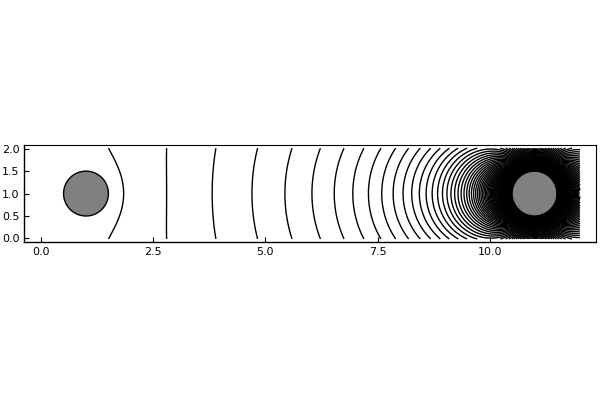

In [248]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=300))
plot!(body_1,fillcolor=:grey,fillrange=0,fillalpha=1.0,linecolor=:black)
plot!(body_2,fillcolor=:grey,fillrange=0,fillalpha=1.0,linecolor=:black)

#### Check added mass coefficient

In [249]:
"""
integrate(f::Function,xmin::Real,xmax::Real,N::Int,name::String) -> Real
Integrate the function `f` between the limits `xmin` to `xmax` with `N` intervals using either the `"trapezoidal"` or `"simpson"` rule specified in `name`. The solution is returned as a Real value.
"""
function surface_integrate(body::Body{N},integrand::Array{Float64,1}) where {N}
    func = Array{Float64,1}(undef, N+1)
    func[1:end-1] .= integrand
    func[end] = integrand[1]
    s = sum(Bodies.dlength(body).*(func[1:end-1] + func[2:end]))
    return s
end

surface_integrate

$\boldsymbol{x}\times\boldsymbol{\gamma}_\mathrm{bt}^{(j)}$

In [254]:
integrand_1_x = (f[1:n]./Bodies.dlength(body_1)).*(body_1.y);
integrand_1_y = -(f[1:n]./Bodies.dlength(body_1)).*(body_1.x);
integrand_2_x = (f[n+1:end]./Bodies.dlength(body_2)).*(body_2.y);
integrand_2_y = -(f[n+1:end]./Bodies.dlength(body_2)).*(body_2.x);
# writedlm("integrand_x_two_bodies.csv",integrand_2_x, ',')
sum(integrand_2_x)

1.1523229565914757

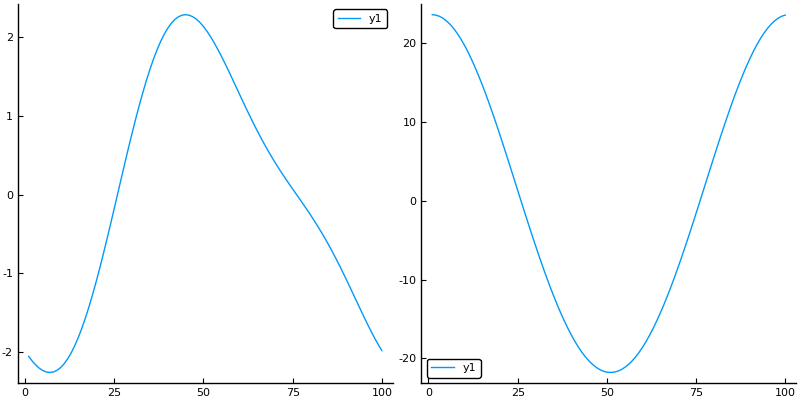

In [251]:
p1 = plot(integrand_2_x)
p2 = plot(integrand_2_y)
p3 = plot(p1,p2,layout=(1,2),size=[800,400])

$P_{\mathrm{bt}}^{(j)}=-\mathcal{V}_{\mathrm{b}} \tilde{\boldsymbol{e}}_{j}+\frac{1}{n_{\mathrm{d}}-1} \int_{S_{\mathrm{b}}} \boldsymbol{x}\times\boldsymbol{\gamma}_\mathrm{bt}^{(j)}\mathrm{d} S$

In [252]:
# P¹ = -𝒱*𝐞₁ + 0.5*[surface_integrate(body_1,integrand_1_x);surface_integrate(body_1,integrand_1_y)]
# P² = -𝒱*𝐞₂ + 0.5*[surface_integrate(body_1,integrand_1_x);surface_integrate(body_1,integrand_1_y)]
# P¹ = -𝒱*𝐞₁ + 0.5*[surface_integrate(body_2,integrand_2_x);surface_integrate(body_2,integrand_2_y)]
P² = -𝒱*𝐞₂ + 0.5*[surface_integrate(body_2,integrand_2_x);surface_integrate(body_2,integrand_2_y)]

2-element Array{Float64,1}:
 0.03619533876969139
 0.43794996377695083

In [253]:
M₁₁ = dot(P¹,𝐞₁)

-0.9674503065279361

Compare the generated vortex sheet `f/ds` with the exact solution

In [34]:
θ = range(0,2π,length=n+1)
fex = -2*cos.(θ[1:n]);
errinf = LinearAlgebra.norm(f[1:n]./ds-fex,Inf)

0.1103432226481531

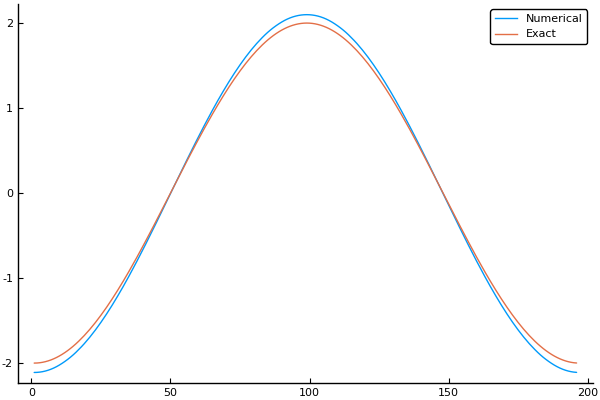

In [35]:
plot(f[1:n]./ds,label="Numerical")
plot!(fex,label="Exact")